# Two 1D interpolations

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.fft as fft
from scipy.interpolate import interp1d

from silx.image.projection import Projection

from ppfft.tools.new_fft import new_fft
from ppfft.tools.pad import pad
from ppfft.tools.grids import domain
from ppfft.tools.phantom_generator import generate_phantom
from ppfft.reconstruction.new_reconstruction import new_reconstruction
from ppfft.inverse.new_onion_peeling import precompute_new_onion_peeling
from ppfft.ppfft.new_ppfft import new_ppfft

## Interpolation along rays

In [2]:
def new_interpolate_vert_ray(theta, ray_samples, n, kind='linear'):
    """
    Interpolate rays corresponding to the vertical PPFFT.
    -pi / 4 <= theta <= pi / 4
    3pi / 4 <= theta <= 5pi / 4

    ``ray_samples`` always goes from the bottom of the circle to the top.
    """
    n_r = len(ray_samples)
    
    ray_pos = domain(n_r) # positions of the known points along the line
    target_pos = domain(n + 1) * np.sqrt(1 + np.tan(theta)**2)

    # Interpolate and put zeros outside of the polar disk
    interpolator = interp1d(ray_pos, ray_samples, bounds_error=False, fill_value="extrapolate", kind=kind)

    return interpolator(target_pos)

    if - np.pi / 4 <= theta <= np.pi / 4:
        res = interpolator(target_pos)
    else:
        res = interpolator(target_pos)[::-1]

    return res


def new_interpolate_all_vert_rays(vert_thetas, vert_polar_ft, n, kind='linear'):
    """
    Computes the first step towards the vertical PPFFT.
    """
    res = np.zeros(shape=(len(vert_thetas), n + 1), dtype=complex)

    for i, theta in enumerate(vert_thetas):
        res[i] = new_interpolate_vert_ray(theta, vert_polar_ft[i], n, kind)

    """
    res = np.zeros(shape=(2 * n + 1, 2 * q_n + 1), dtype=complex)

    i = 0
    for q in range(n - q_n, n):
        res[:, i] = new_interpolate_vert_ray(q, polar_ft[:, q], kind)
        i += 1

    res[:, i] = polar_ft[:, 0] # theta = 0, horizontal coordinates
    i += 1

    for q in range(1, q_n + 1):
        res[:, i] = new_interpolate_vert_ray(q, polar_ft[:, q], kind)
        i += 1

    return res[::, ::-1]
    """

    return res


def new_interpolate_hori_ray(theta, ray_samples, n, kind='linear'):
    """
    Interpolate rays corresponding to the horizontal PPFFT.
    pi / 4 <= theta <= 3pi / 4
    -pi/4 <= theta <= -3pi / 4
    """
    n_r = len(ray_samples)
    
    ray_pos = domain(n_r) # positions of the known points along the line
    target_pos = domain(n + 1) * np.sqrt(1 + 1 / np.tan(theta)**2)
    
    # Interpolate and put zeros outside of the polar disk
    interpolator = interp1d(ray_pos, ray_samples, bounds_error=False, fill_value="extrapolate", kind=kind)

    return interpolator(target_pos)


def new_interpolate_all_hori_rays(hori_thetas, hori_polar_ft, n, kind='linear'):
    """
    Computes the first step towards the horizontal PPFFT.
    """

    res = np.zeros(shape=(len(hori_thetas), n + 1), dtype=complex)

    for i, theta in enumerate(hori_thetas):
        res[i] = new_interpolate_hori_ray(theta, hori_polar_ft[i], n, kind)

    """n = np.shape(polar_ft)[1]
    q_n, r_n = divmod(n, 4)

    res = np.zeros(shape=(2 * n + 1, 2 * q_n + 1), dtype=complex)

    i = 0

    for q in range(n // 4 + (r_n != 0), n // 2):
        res[:, i] = new_interpolate_hori_ray(q, polar_ft[:, q], kind)
        i += 1

    res[:, i] = polar_ft[:, n // 2]
    i += 1

    for q in range(n // 2 + 1, n - n // 4 - (r_n != 0) + 1):
        res[:, i] = new_interpolate_hori_ray(q, polar_ft[:, q], kind)
        i += 1

    return res"""

    return res

In [3]:
def new_interpolate_vert_angle(vert_thetas, k, n, samples, kind='linear'):
    """
    Reconstruct one column of the vertical PPFFT.
    -n/2 <= k <= n/2
    """

    samples_pos = k * np.tan(vert_thetas)

    # Initialize interpolator
    interpolator = interp1d(samples_pos, samples, bounds_error=False, fill_value="extrapolate", kind=kind)

    # The target y positions are: y_l = -2lk / n with -n/2 <= l <= n/2
    target_pos = domain(n + 1) * (-2 * k / n)

    """res = np.zeros_like(target_pos, dtype=complex)
    res[1:-1] = interpolator(target_pos[1:-1])
    res[0] = samples[0]
    res[-1] = samples[-1]

    return res"""

    # Compute result
    return interpolator(target_pos)
    

def new_interpolate_hori_angle(hori_thetas, k, n, samples, kind='linear'):
    """
    Reconstruct one line of the horizontal PPFFT.
    -n <= k <= n
    """

    # samples at y = k
    # and angles pi * q / 2n with n/2 <= q <= n + n/2
    # meaning the x positions are: x_q = k / tan(theta_q)
    samples_pos = k / np.tan(hori_thetas)

    # Initialize interpolator
    interpolator = interp1d(samples_pos, samples, bounds_error=False, fill_value="extrapolate", kind=kind)

    # The target x positions are: x_l = -2lk / n with -n/2 <= l <= n/2
    target_pos = domain(n + 1) * (-2 * k / n)

    # Compute result
    """res = np.zeros_like(target_pos, dtype=complex)
    res[0] = samples[0] # the first point is already known
    res[-1] = samples[-1] # the last one too
    res[1:-1] = interpolator(target_pos[1:-1])

    return res"""

    return interpolator(target_pos)
    

def new_interpolate_all_vert_angles(vert_thetas, vert_rays, kind='linear'):
    """
    ``vert_rays`` is the ouput of ``interpolate_all_vert_rays``.
    Its shape is (n_theta, n + 1)
    """
    n = np.shape(vert_rays)[1] - 1
    vert_ppfft = np.zeros(shape=(n // 2 + 1, n + 1), dtype=complex)

    for k in np.arange(0, n // 2 + 1):
        if k != 0:
            samples = vert_rays[:, k + n // 2]
            vert_ppfft[k] = new_interpolate_vert_angle(vert_thetas, k, n, samples, kind)
        else:
            vert_ppfft[k] = vert_rays[0, n // 2]

    return vert_ppfft


def new_interpolate_all_hori_angles(hori_thetas, hori_rays, kind='linear'):
    """
    ``hori_rays`` is the ouput of ``interpolate_all_hori_rays``.
    Its shape is (n_theta, n + 1)
    """
    n = np.shape(hori_rays)[1] - 1
    hori_ppfft = np.zeros(shape=(n // 2 + 1, n + 1), dtype=complex)

    for k in np.arange(0, n // 2 + 1):
        if k != 0:
            samples = hori_rays[:, k + n // 2]
            hori_ppfft[k] = new_interpolate_hori_angle(hori_thetas, k, n, samples, kind)
        else:
            hori_ppfft[k] = hori_rays[0, n // 2]

    return hori_ppfft

In [4]:
def new_polar_to_pseudopolar(thetas, polar_ft, n, kind='linear'):
    """
    0 <= thetas <= pi
    """
    mask = np.logical_and(np.pi / 4 <= thetas, thetas <= 3 * np.pi / 4)

    hori_thetas, vert_thetas = thetas[mask], thetas[~mask]

    hori_polar_ft, vert_polar_ft = polar_ft[mask], polar_ft[~mask]

    vert_rays = new_interpolate_all_vert_rays(vert_thetas, vert_polar_ft, n, kind)
    hori_rays = new_interpolate_all_hori_rays(hori_thetas, hori_polar_ft, n, kind)
    vert_ppfft = new_interpolate_all_vert_angles(vert_thetas, vert_rays, kind)
    hori_ppfft = new_interpolate_all_hori_angles(hori_thetas, hori_rays, kind)

    return hori_ppfft, vert_ppfft

# Test

In [5]:
n = 400
precomputations = precompute_new_onion_peeling(n)

In [6]:
im = generate_phantom(n)

thetas = np.linspace(-np.pi/2, np.pi/2, endpoint=False, num=n)

n_r = 4 * n + 1
proj = Projection(im.shape, angles=thetas)
sinogram = proj.projection(im)
pad_sino = pad(sinogram, (n, n_r))
fft_sinogram = new_fft(pad_sino)

In [7]:
angles = np.pi / 2 + thetas
fft_sinogram *= np.exp(-2j * np.pi * (domain(n_r) / n_r)[None, :] * (n // 2) * (np.cos(angles) + np.sin(angles))[:, None])

In [8]:
hori, vert = new_polar_to_pseudopolar(angles, fft_sinogram, n, 'cubic')

[None, None, None, None]

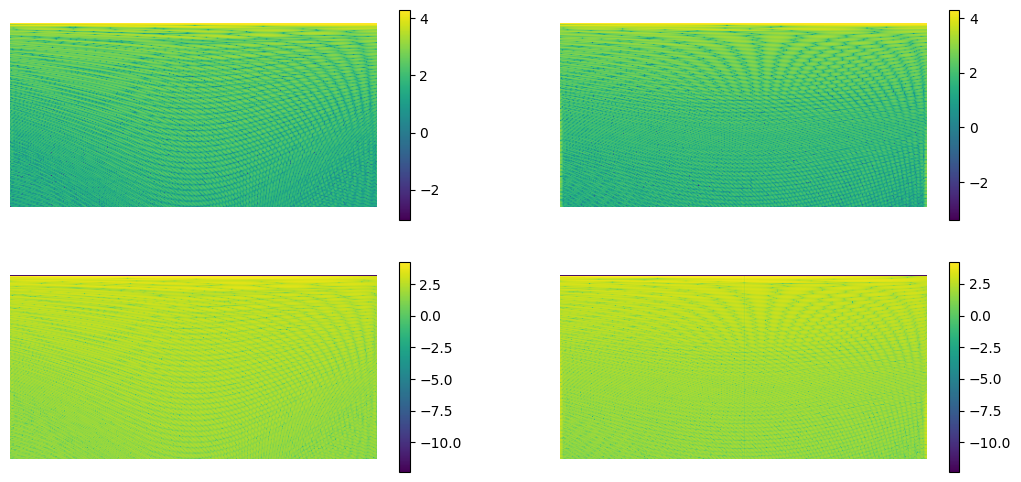

In [9]:
fig, axes = plt.subplots(2, 2, figsize=(13, 6))

c = axes[0, 0].imshow(np.log10(np.abs(hori.real)))
plt.colorbar(c, ax=axes[0, 0])
c = axes[0, 1].imshow(np.log10(np.abs(vert.real)))
plt.colorbar(c, ax=axes[0, 1])
c = axes[1, 0].imshow(np.log10(np.abs(hori.imag)))
plt.colorbar(c, ax=axes[1, 0])
c = axes[1, 1].imshow(np.log10(np.abs(vert.imag)))
plt.colorbar(c, ax=axes[1, 1])

[ax.set_axis_off() for ax in axes.ravel()]

In [10]:
true_hori, true_vert = new_ppfft(im)

/tmp/ipykernel_1798702/2893954219.py:7: RuntimeWarning: divide by zero encountered in log10
  c = axes[1, 0].imshow(np.log10(np.abs(true_hori.imag)))
/tmp/ipykernel_1798702/2893954219.py:9: RuntimeWarning: divide by zero encountered in log10
  c = axes[1, 1].imshow(np.log10(np.abs(true_vert.imag)))


[None, None, None, None]

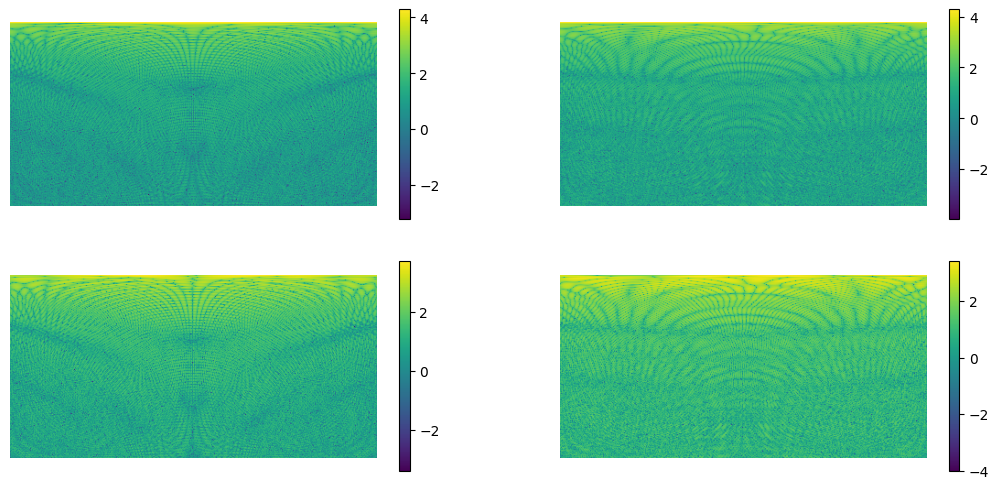

In [11]:
fig, axes = plt.subplots(2, 2, figsize=(13, 6))

c = axes[0, 0].imshow(np.log10(np.abs(true_hori.real)))
plt.colorbar(c, ax=axes[0, 0])
c = axes[0, 1].imshow(np.log10(np.abs(true_vert.real)))
plt.colorbar(c, ax=axes[0, 1])
c = axes[1, 0].imshow(np.log10(np.abs(true_hori.imag)))
plt.colorbar(c, ax=axes[1, 0])
c = axes[1, 1].imshow(np.log10(np.abs(true_vert.imag)))
plt.colorbar(c, ax=axes[1, 1])

[ax.set_axis_off() for ax in axes.ravel()]

# Old definition

In [12]:
from ppfft.ppfft.ppfft import ppfft

In [13]:
true_hori, true_vert = ppfft(im)

/tmp/ipykernel_1798702/2893954219.py:7: RuntimeWarning: divide by zero encountered in log10
  c = axes[1, 0].imshow(np.log10(np.abs(true_hori.imag)))
/tmp/ipykernel_1798702/2893954219.py:9: RuntimeWarning: divide by zero encountered in log10
  c = axes[1, 1].imshow(np.log10(np.abs(true_vert.imag)))


[None, None, None, None]

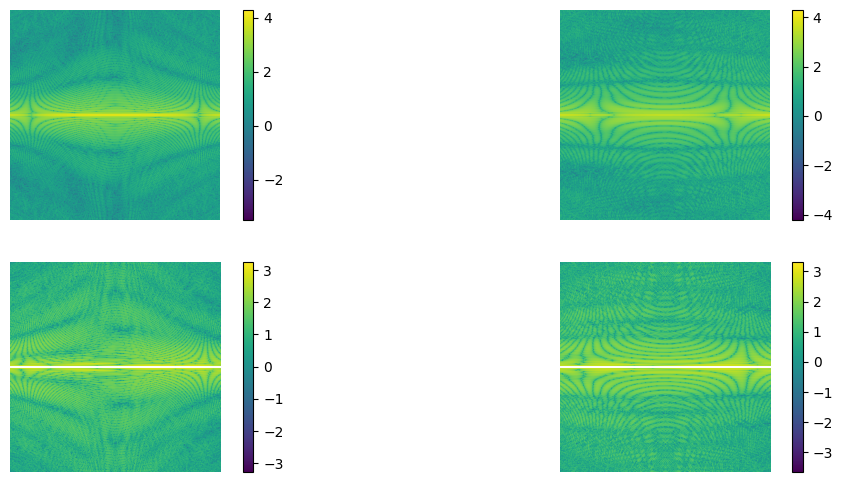

In [14]:
fig, axes = plt.subplots(2, 2, figsize=(13, 6))

c = axes[0, 0].imshow(np.log10(np.abs(true_hori.real)))
plt.colorbar(c, ax=axes[0, 0])
c = axes[0, 1].imshow(np.log10(np.abs(true_vert.real)))
plt.colorbar(c, ax=axes[0, 1])
c = axes[1, 0].imshow(np.log10(np.abs(true_hori.imag)))
plt.colorbar(c, ax=axes[1, 0])
c = axes[1, 1].imshow(np.log10(np.abs(true_vert.imag)))
plt.colorbar(c, ax=axes[1, 1])

[ax.set_axis_off() for ax in axes.ravel()]

In [15]:
def new_interpolate_vert_ray(q, ray_samples, kind='linear'):
    """
    Interpolate rays corresponding to the vertical PPFFT.
    0 <= q <= n // 4 or n - n // 4 <= q <= n - 1

    ``ray_samples`` always goes from the bottom of the circle to the top.
    """
    n = (len(ray_samples) - 1) // 2

    ray_pos = np.arange(-n, n + 1) # positions of the known points along the line
    theta = np.pi * q / n
    target_pos = np.arange(-n, n + 1) * np.sqrt(1 + np.tan(theta)**2)

    # Interpolate and put zeros outside of the polar disk
    interpolator = interp1d(ray_pos, ray_samples, bounds_error=False, fill_value=0, kind=kind)

    if 0 <= q <= n // 4:
        res = interpolator(target_pos)
    else:
        res = interpolator(target_pos)[::-1]

    return res


def new_interpolate_all_vert_rays(polar_ft, kind='linear'):
    """
    Computes the first step towards the vertical PPFFT.

    polar_ft has shape: (2n + 1, n)
    """
    n = np.shape(polar_ft)[1]
    q_n, r_n = divmod(n, 4)

    res = np.zeros(shape=(2 * n + 1, 2 * q_n + 1), dtype=complex)

    i = 0
    for q in range(n - q_n, n):
        res[:, i] = new_interpolate_vert_ray(q, polar_ft[:, q], kind)
        i += 1

    res[:, i] = polar_ft[:, 0] # theta = 0, horizontal coordinates
    i += 1

    for q in range(1, q_n + 1):
        res[:, i] = new_interpolate_vert_ray(q, polar_ft[:, q], kind)
        i += 1

    return res[::, ::-1]


def new_interpolate_hori_ray(q, ray_samples, kind='linear'):
    """
    Interpolate rays corresponding to the horizontal PPFFT.
    n // 4 + ((n % 4) != 0) <= q <= n - n // 4 - ((n % 4) != 0)
    """
    n = (len(ray_samples) - 1) // 2
    
    ray_pos = np.arange(-n, n + 1) # positions of the known points along the line
    theta = np.pi * q / n
    target_pos = np.arange(-n, n + 1) * np.sqrt(1 + 1 / np.tan(theta)**2)
    
    # Interpolate and put zeros outside of the polar disk
    interpolator = interp1d(ray_pos, ray_samples, bounds_error=False, fill_value=0, kind=kind)

    return interpolator(target_pos)


def new_interpolate_all_hori_rays(polar_ft, kind='linear'):
    """
    Computes the first step towards the horizontal PPFFT.
    """
    n = np.shape(polar_ft)[1]
    q_n, r_n = divmod(n, 4)

    res = np.zeros(shape=(2 * n + 1, 2 * q_n + 1), dtype=complex)

    i = 0

    for q in range(n // 4 + (r_n != 0), n // 2):
        res[:, i] = new_interpolate_hori_ray(q, polar_ft[:, q], kind)
        i += 1

    res[:, i] = polar_ft[:, n // 2]
    i += 1

    for q in range(n // 2 + 1, n - n // 4 - (r_n != 0) + 1):
        res[:, i] = new_interpolate_hori_ray(q, polar_ft[:, q], kind)
        i += 1

    return res

In [16]:
def new_interpolate_vert_angle(k, n, samples, kind='linear'):
    """
    Reconstruct one column of the horizontal PPFFT.
    -n <= k <= n
    """
    q_n, r_n = divmod(n, 4)

    # samples at x = k
    # and angles pi * q / 2n with q = n/2, ... 0, 2n-1, ..., n + n/2
    # meaning the y positions are: x_q = k * tan(theta_q)
    q = np.concatenate((np.arange(0, q_n + 1)[::-1], np.arange(n - q_n, n)[::-1]))
    samples_pos = k * np.tan(np.pi * q / n)

    # Initialize interpolator
    interpolator = interp1d(samples_pos, samples, bounds_error=False, fill_value=0, kind=kind)

    # The target y positions are: y_l = -2lk / n with -n/2 <= l <= n/2
    target_pos = np.arange(-(n//2), n//2 + 1) * (-2 * k / n)

    # Compute result
    res = np.zeros_like(target_pos, dtype=complex)
    res[1:-1] = interpolator(target_pos[1:-1])
    res[0] = samples[0]
    res[-1] = samples[-1]

    return res


def new_interpolate_hori_angle(k, n, samples, kind='linear'):
    """
    Reconstruct one line of the horizontal PPFFT.
    -n <= k <= n
    """
    q_n, r_n = divmod(n, 4)

    # samples at y = k
    # and angles pi * q / 2n with n/2 <= q <= n + n/2
    # meaning the x positions are: x_q = k / tan(theta_q)
    samples_pos = k / np.tan(np.pi * np.arange(q_n + (r_n != 0), n - q_n - (r_n != 0) + 1) / n)

    # Initialize interpolator
    interpolator = interp1d(samples_pos, samples, bounds_error=False, fill_value=0, kind=kind)

    # The target x positions are: x_l = -2lk / n with -n/2 <= l <= n/2
    target_pos = np.arange(-(n//2), n//2 + 1) * (-2 * k / n)

    # Compute result
    res = np.zeros_like(target_pos, dtype=complex)
    res[0] = samples[0] # the first point is already known
    res[-1] = samples[-1] # the last one too
    res[1:-1] = interpolator(target_pos[1:-1])

    return res
    

def new_interpolate_all_vert_angles(vert_rays, kind='linear'):
    """
    ``vert_rays`` is the ouput of ``interpolate_all_vert_rays``.
    Its shape is (2n+1, 2 * (n // 4) + 1)
    """
    n = np.shape(vert_rays)[0] // 2
    vert_ppfft = np.zeros(shape=(2 * n + 1, n + 1), dtype=complex)

    for k in np.arange(-n, n + 1):
        if k != 0:
            samples = vert_rays[k + n]
            vert_ppfft[k + n] = new_interpolate_vert_angle(k, n, samples, kind)
        else:
            vert_ppfft[k + n] = vert_rays[k + n, n // 4]

    return vert_ppfft.T


def new_interpolate_all_hori_angles(hori_rays, kind='linear'):
    """
    ``hori_rays`` is the ouput of ``interpolate_all_hori_rays``.
    Its shape is (2n+1, 2 * (n // 4) + 1)
    """
    n = np.shape(hori_rays)[0] // 2
    hori_ppfft = np.zeros(shape=(2 * n + 1, n + 1), dtype=complex)

    for k in np.arange(-n, n + 1):
        if k != 0:
            samples = hori_rays[k + n]
            hori_ppfft[k + n] = new_interpolate_vert_angle(k, n, samples, kind)
        else:
            hori_ppfft[k + n] = hori_rays[k + n, n // 4]

    return hori_ppfft.T

In [17]:
def new_polar_to_pseudopolar(polar_ft, kind='linear'):
    vert_rays = new_interpolate_all_vert_rays(polar_ft, kind)
    hori_rays = new_interpolate_all_hori_rays(polar_ft, kind)
    vert_ppfft = new_interpolate_all_vert_angles(vert_rays, kind)
    hori_ppfft = new_interpolate_all_hori_angles(hori_rays, kind)

    return hori_ppfft, vert_ppfft

In [18]:
def new_polar_fourier_transform(im):
    n = len(im)
    m = 2 * n + 1
    half_n = n // 2
    p = np.arange(-n, n + 1) / m
    q = np.arange(0, n)
    u, v = np.arange(-half_n, half_n), np.arange(-half_n, half_n)

    cos = -2j * np.pi * np.einsum("k,u,l->kul", p, u, np.cos(np.pi * q / n))
    sin = -2j * np.pi * np.einsum("k,v,l->kvl", p, v, np.sin(np.pi * q / n))

    res = np.einsum("uv,kul,kvl->kl", im, np.exp(cos), np.exp(sin))

    return res